In [ ]:
# Standard packages
import numpy as np
import matplotlib.pyplot as plt

# For data preprocessing and augmentation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#allow us to open the data
import h5py
import os

#The data set was too large to import from GitHub so we each uploaded the file
#to our drive and imported using the following code
#The professor said to just provide
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/dataset_ts_light_version.hdf5"


Mounted at /content/drive


x_test: shape = (7766, 48, 48, 3)
x_train: shape = (90601, 48, 48, 3)
x_validation: shape = (31063, 48, 48, 3)
y_test: shape = (7766,)
y_train: shape = (90601,)
y_validation: shape = (31063,)
Train images shape: (90601, 48, 48, 3)
Train images dtype: float32
Train labels shape: (90601,)


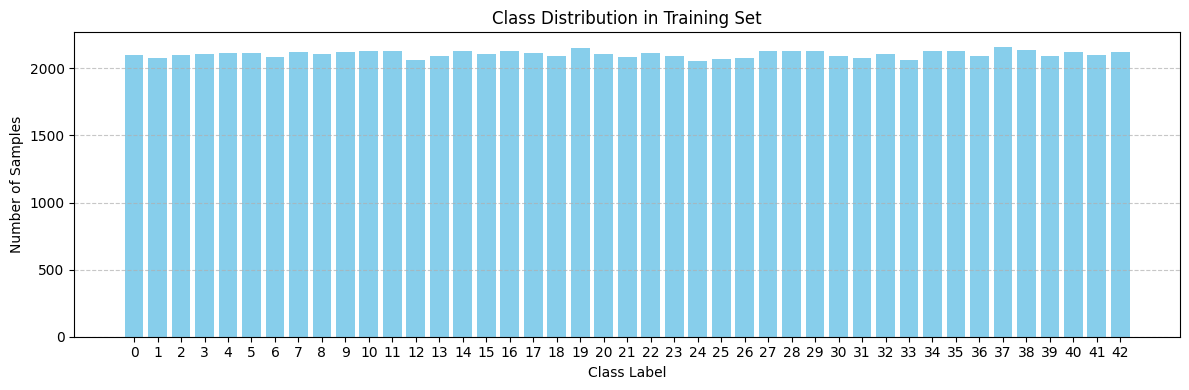

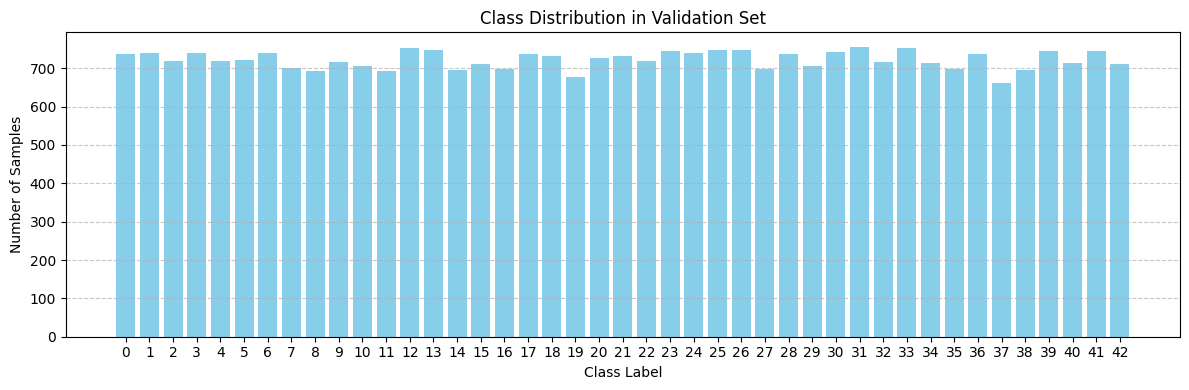

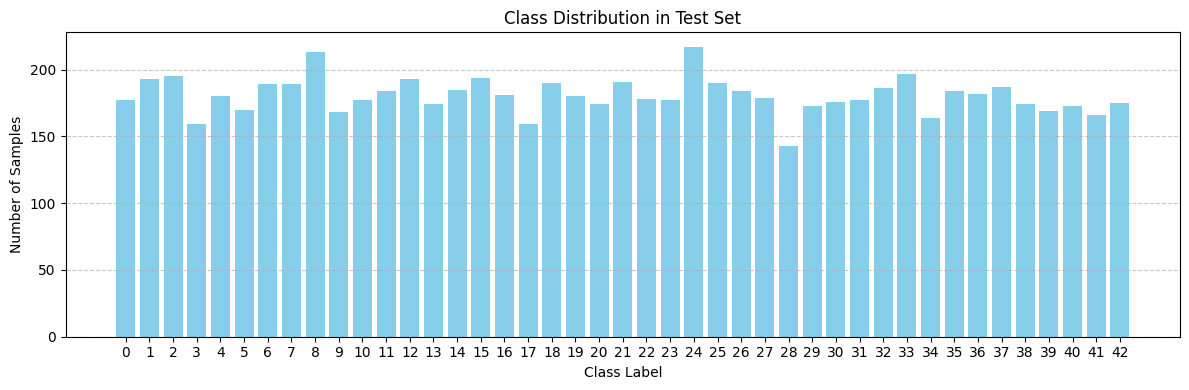

In [ ]:
# Open and inspect the dataset
with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        print(f"{key}: shape = {f[key].shape}")

    # Load only first 10 samples from each set
    X_train = f['x_train'][:]
    y_train = f['y_train'][:]

    X_val = f['x_validation'][:]
    y_val = f['y_validation'][:]

    X_test = f['x_test'][:]
    y_test = f['y_test'][:]

#The data is pre-split into a train, validation and test set
print("Train images shape:", X_train.shape)
print("Train images dtype:", X_train.dtype)
print("Train labels shape:", y_train.shape)



#Function to make observations of each of the sets
def plot_class_distribution(y_data, dataset_name):
    class_counts = np.bincount(y_data, minlength=43)
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(43), class_counts, color='skyblue')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xlabel('Class Label')
    plt.ylabel('Number of Samples')
    plt.xticks(np.arange(43))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot each dataset, the data is pre-split into a train, validation and test set
plot_class_distribution(y_train, "Training")
plot_class_distribution(y_val, "Validation")
plot_class_distribution(y_test, "Test")


In [ ]:
# check if it's already normalized
with h5py.File(file_path, 'r') as f:
    images = f['x_train'][:]
    print("Min pixel value:", np.min(images))
    print("Max pixel value:", np.max(images))

Min pixel value: 0.0
Max pixel value: 255.0


In [ ]:
#This funtion was made to remove any corrupted, mislabled and blank images
#It ended up being redundant as our file had no images of this type
def find_invalid_images(X, y):
    invalid_indices = []
    valid_labels = set(range(43))  # labels are from 0 to 42

    for i, (img, label) in enumerate(zip(X, y)):
        if np.isnan(img).any():
            print(f"Image {i} contains NaN values.")
            invalid_indices.append(i)
            continue
        if img.std() == 0:
            print(f"Image {i} has zero standard deviation.")
            invalid_indices.append(i)
            continue
        if label not in valid_labels:
            print(f"Label {label} at index {i} is invalid.")
            invalid_indices.append(i)
    return invalid_indices

invalid_train = find_invalid_images(X_train, y_train)
invalid_val = find_invalid_images(X_val, y_val)
invalid_test = find_invalid_images(X_test, y_test)

print("Invalid indices in train set:", invalid_train)
print("Invalid indices in validation set:", invalid_val)
print("Invalid indices in test set:", invalid_test)


#Additionally, we did not augment the data because after looking at the
#documentation of the data set, we realized the data comes pre-augmented

Invalid indices in train set: []
Invalid indices in validation set: []
Invalid indices in test set: []


In [ ]:
# Normalize all datasets by dividing by 255.0
#be careful running twice overnormalizes
X_train = X_train.astype(np.float32) / 255.0
X_val = X_val.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

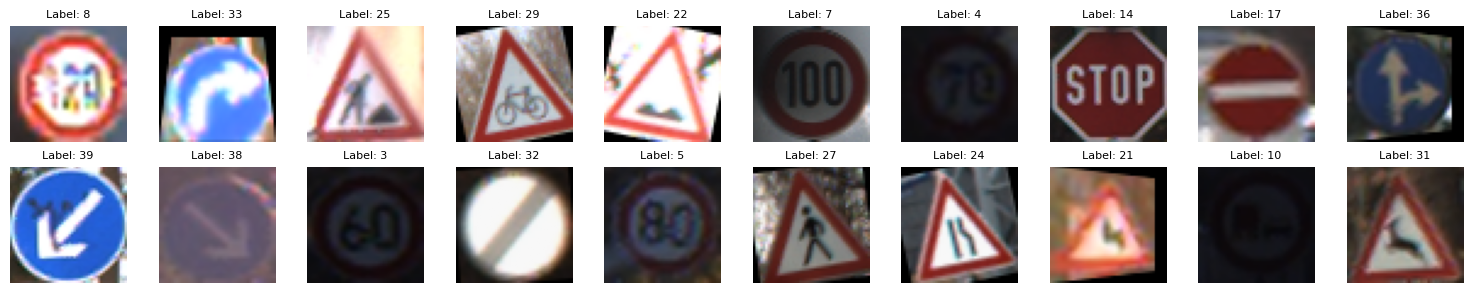

In [ ]:
#data visualization
def plot_image_grid(images, labels, class_names=None, num_images=20):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i + 1)
        plt.imshow(images[i])
        title = f"Label: {labels[i]}"
        if class_names:
            title = class_names[labels[i]]
        plt.title(title, fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call with training data
plot_image_grid(X_train, y_train)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

model = models.Sequential([
    # Block 1
    Input(shape=(48, 48, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(), # --> (48 x 48 x 32)
    layers.MaxPooling2D((2, 2)), # --> (24 x 24 x 32)

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(), # --> (24 x 24 x 64)
    layers.MaxPooling2D((2, 2)), # --> (12 x 12 x 64)

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(), # --> (12 x 12 x 128)
    layers.MaxPooling2D((2, 2)), # --> (6 x 6 x 128)
    layers.Dropout(0.4),

    # Flatten and Dense Layers
    layers.Flatten(), # --> (4608,)
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(43, activation='softmax')  # 43 means number of labels
])


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.5533 - loss: 1.7200 - val_accuracy: 0.9858 - val_loss: 0.0474
Epoch 2/10
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9562 - loss: 0.1467 - val_accuracy: 0.9900 - val_loss: 0.0339
Epoch 3/10
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9703 - loss: 0.1051 - val_accuracy: 0.9889 - val_loss: 0.0375
Epoch 4/10
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9767 - loss: 0.0847 - val_accuracy: 0.9956 - val_loss: 0.0169
Epoch 5/10
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9811 - loss: 0.0674 - val_accuracy: 0.9939 - val_loss: 0.0224
Epoch 6/10
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9821 - loss: 0.0699 - val_accuracy: 0.9941 - val_loss: 0.0200
Epoch 7/10
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9848 - loss: 0.0571 - val_accuracy: 0.9955 - val_loss: 0.0161
Epoch 8/10
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9867 - loss: 0.04

In [ ]:
import tensorflow as tf
from tensorflow.keras import callbacks, optimizers, losses, metrics

#hyper-parameters
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.20
INIT_LR = 1e-3
PATIENCE = 5 # for early stopping

model.compile(
    optimizer=optimizers.Adam(learning_rate=INIT_LR),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'] # Keras maps to sparse_categorical_accuracy
)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    callbacks=[
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            verbose=1
        )
    ],
    verbose=2 # compact, but still shows epoch metrics
)


Epoch 1/30
1133/1133 - 24s - 21ms/step - accuracy: 0.7662 - loss: 0.8263 - val_accuracy: 0.9802 - val_loss: 0.0650 - learning_rate: 1.0000e-03
Epoch 2/30
1133/1133 - 9s - 8ms/step - accuracy: 0.9594 - loss: 0.1389 - val_accuracy: 0.9912 - val_loss: 0.0281 - learning_rate: 1.0000e-03
Epoch 3/30
1133/1133 - 10s - 9ms/step - accuracy: 0.9725 - loss: 0.0959 - val_accuracy: 0.9911 - val_loss: 0.0293 - learning_rate: 1.0000e-03
Epoch 4/30
1133/1133 - 9s - 8ms/step - accuracy: 0.9777 - loss: 0.0829 - val_accuracy: 0.9953 - val_loss: 0.0150 - learning_rate: 1.0000e-03
Epoch 5/30
1133/1133 - 11s - 9ms/step - accuracy: 0.9801 - loss: 0.0731 - val_accuracy: 0.9903 - val_loss: 0.0361 - learning_rate: 1.0000e-03
Epoch 6/30

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1133/1133 - 9s - 8ms/step - accuracy: 0.9834 - loss: 0.0629 - val_accuracy: 0.9920 - val_loss: 0.0282 - learning_rate: 1.0000e-03
Epoch 7/30
1133/1133 - 9s - 8ms/step - accuracy: 0.9914 - loss: 0.0301 - 

In [ ]:
!pip install keras-tuner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

# 1) Define the model‐building function for the tuner
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(48, 48, 3)))

    # Conv block 1
    filters1 = hp.Choice('filters1', [32, 64])
    model.add(layers.Conv2D(filters1, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv block 2
    filters2 = hp.Choice('filters2', [64, 128])
    model.add(layers.Conv2D(filters2, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv block 3 + dropout
    filters3 = hp.Choice('filters3', [128, 256])
    model.add(layers.Conv2D(filters3, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    drop_conv = hp.Float('dropout_conv', 0.2, 0.5, step=0.1)
    model.add(layers.Dropout(drop_conv))

    # Dense head
    model.add(layers.Flatten())
    units_dense = hp.Int('units_dense', min_value=128, max_value=512, step=128)
    model.add(layers.Dense(units_dense, activation='relu'))
    drop_dense = hp.Float('dropout_dense', 0.3, 0.6, step=0.1)
    model.add(layers.Dropout(drop_dense))
    model.add(layers.Dense(43, activation='softmax'))

    # Compile
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model

# 2) Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,               # total models to try
    executions_per_trial=1,      # no. of re-runs per trial
    directory='kt_tuner_dir',
    project_name='cnn_hyperparam'
)

# 3) Set up the callbacks you want during search
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

# 4) Run the hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# 5) Retrieve the best hyperparameters and model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hp.values)

# TESTING
best_model = tuner.get_best_models(num_models=1)[0]

# 6) Further train / fine-tune the best model
history = best_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# 7) Evaluate on your held-out test set
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Trial 3 Complete [00h 07m 23s]
val_accuracy: 0.9992595911026001

Best val_accuracy So Far: 0.9992595911026001
Total elapsed time: 00h 24m 09s
Best hyperparameters: {'filters1': 64, 'filters2': 64, 'filters3': 256, 'dropout_conv': 0.30000000000000004, 'units_dense': 128, 'dropout_dense': 0.5, 'learning_rate': 0.00010622591214381281}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
1133/1133 - 26s - 23ms/step - accuracy: 0.9967 - loss: 0.0096 - val_accuracy: 0.9997 - val_loss: 0.0014 - learning_rate: 1.0623e-04
Epoch 2/10
1133/1133 - 31s - 27ms/step - accuracy: 0.9964 - loss: 0.0114 - val_accuracy: 0.9999 - val_loss: 3.5857e-04 - learning_rate: 1.0623e-04
Epoch 3/10
1133/1133 - 13s - 11ms/step - accuracy: 0.9969 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 1.4582e-04 - learning_rate: 1.0623e-04
Epoch 4/10
1133/1133 - 20s - 18ms/step - accuracy: 0.9970 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 1.2298e-04 - learning_rate: 1.0623e-04
Epoch 5/10

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.3112955356482416e-05.
1133/1133 - 21s - 18ms/step - accuracy: 0.9976 - loss: 0.0081 - val_accuracy: 0.9999 - val_loss: 6.5794e-04 - learning_rate: 1.0623e-04
Epoch 6/10
1133/1133 - 22s - 19ms/step - accuracy: 0.9982 - loss: 0.0058 - val_accuracy: 1.0000 - val_loss: 8.3564e-05 - learning_rate: 5.3113e-05
Epoch 7/10

Epoch 7: ReduceLROnPlateau reduc

In [ ]:
# Save the trained model
best_model.save('best_cnn.keras')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# Load the saved model
#loaded_model = load_model('best_cnn.keras')
y_pred_probs = best_model.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)

# Generate Confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred, normalize='true')
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical', colorbar=True)
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

# Generate classification report
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(4)

fig, ax = plt.subplots(figsize=(10, len(report_df)*0.5))
ax.axis('off')

# Create table
table = ax.table(
    cellText=report_df.values,
    colLabels=report_df.columns,
    rowLabels=report_df.index,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.tight_layout()
plt.show()


